In [1]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils

BDC is using numpy


In [2]:
@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr

STANDARDIZED INITIAL VARBS

In [3]:
T_SPECTRA = 4096/250e6

global_start_time = 1721800002
iteration_time = 3600

c_acclen = 10**6 
v_acclen = 30000

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((iteration_time)/C_T_ACCLEN)
v_nchunks = int((iteration_time)/V_T_ACCLEN)

a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"

a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2
tle_path = outils.get_tle_file(1721800002, "/project/s/sievers/mohanagr/OCOMM_TLES")

In [4]:
idx_correction=109993-100000

EXAMPLE PASSES

From satellite_detection script. Note that there exists some mechanism here to decide on which passes to use, and which also contains information about which satellite it is.

In [5]:
passes = [[[143, 222], [3]], [[990, 1054], [1]], [[1400, 1429], [3]], [[1723, 1794], [0]], [[2195, 2288], [1]], [[2926, 3022], [0]], [[3401, 3506], [1]]]

for i in range(len(passes)):
    passes[i][0] = (np.array(passes[i][0]) * 5).tolist()

print(passes)

for i in range(len(passes)):
    print(f"Pass {i} in seconds offset:", passes[i][0])

start_times = [ p[0][0] for p in passes]
print(start_times)
durations_secs = [p[0][1]- p[0][0] for p in passes]
print(durations_secs)
durations_chunks = [int((p[0][1]- p[0][0])/( T_SPECTRA * v_acclen )) for p in passes]
print(durations_chunks)

[[[715, 1110], [3]], [[4950, 5270], [1]], [[7000, 7145], [3]], [[8615, 8970], [0]], [[10975, 11440], [1]], [[14630, 15110], [0]], [[17005, 17530], [1]]]
Pass 0 in seconds offset: [715, 1110]
Pass 1 in seconds offset: [4950, 5270]
Pass 2 in seconds offset: [7000, 7145]
Pass 3 in seconds offset: [8615, 8970]
Pass 4 in seconds offset: [10975, 11440]
Pass 5 in seconds offset: [14630, 15110]
Pass 6 in seconds offset: [17005, 17530]
[715, 4950, 7000, 8615, 10975, 14630, 17005]
[395, 320, 145, 355, 465, 480, 525]
[803, 651, 295, 722, 946, 976, 1068]


<h1 style="font-size:30pt">Get Observed Phases</h1>

Let's pretend we have one antenna and one pulse, for simplicity.

In [6]:
n=1
buffer = 0

In [7]:

t_start = global_start_time + start_times[n] + buffer
t_end = t_start + iteration_time

files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

print('initial offset:', idx1-idx2)

if idx_correction>0:
    idx1+=idx_correction
else:
    idx2+=np.abs(idx_correction)

print('final offset:', idx1-idx2)

channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
nchans=chanend-chanstart

ant1 = bdc.BasebandFileIterator(files_a1, 0, idx1, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')
ant2 = bdc.BasebandFileIterator(files_a2, 0, idx2, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')

initial offset: 976563
final offset: 986556
Not reading any data
ACCLEN RECEIVED IS 30000
took 0.224 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721804929.raw
START SPECNUM IS 1291903660 obj start at 1290489858
ACCLEN RECEIVED IS 30000
took 1.422 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721804945.raw
START SPECNUM IS 1348147319 obj start at 1347720073


In [8]:
p0_a1 = np.zeros((v_acclen, nchans), dtype="complex128") #remember that BDC returns complex64. wanna do phase-centering in 128.
p0_a2 = np.zeros((v_acclen, nchans), dtype="complex128")
a1_start = ant1.spec_num_start
a2_start = ant2.spec_num_start
for i, (chunk1, chunk2) in enumerate(zip(ant1, ant2)):
    perc_missing_a1 = (1 - len(chunk1["specnums"]) / v_acclen) * 100
    perc_missing_a2 = (1 - len(chunk2["specnums"]) / v_acclen) * 100
    print("missing a1", perc_missing_a1, "missing a2", perc_missing_a2)
    if perc_missing_a1 > 10 or perc_missing_a2 > 10:
        a1_start = ant1.spec_num_start
        a2_start = ant2.spec_num_start
        print("skipping")
        continue
    print(chunk1["specnums"] - a1_start)
    outils.make_continuous(
        p0_a1, chunk1["pol0"], chunk1["specnums"] - a1_start
    )
    outils.make_continuous(
        p0_a2, chunk2["pol0"], chunk2["specnums"] - a2_start
    )
    break

missing a1 0.0 missing a2 0.0
[    0     1     2 ... 29997 29998 29999]


In [9]:
m1=ant1.spec_num_start
m2=ant2.spec_num_start
visibility_phased = np.zeros((v_nchunks,len(ant1.channel_idxs)), dtype='complex64')
st=time.time()
print(f"--------- Processing Pulse Idx {n} ---------")
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
        xcorr = avg_xcorr_4bit_2ant_float(
            chunk1['pol0'], 
            chunk2['pol0'],
            chunk1['specnums'],
            chunk2['specnums'],
            m1+i*v_acclen,
            m2+i*v_acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/v_acclen
        print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)
vis_phase = np.angle(visibility_phased)

--------- Processing Pulse Idx 1 ---------
CHUNK 0  has  30000  rows
CHUNK 1  has  30000  rows
CHUNK 2  has  30000  rows
CHUNK 3  has  30000  rows
CHUNK 4  has  30000  rows
CHUNK 5  has  30000  rows
CHUNK 6  has  30000  rows
CHUNK 7  has  30000  rows
CHUNK 8  has  30000  rows
CHUNK 9  has  30000  rows
CHUNK 10  has  30000  rows
CHUNK 11  has  30000  rows
CHUNK 12  has  30000  rows
CHUNK 13  has  30000  rows
CHUNK 14  has  30000  rows
CHUNK 15  has  30000  rows
CHUNK 16  has  30000  rows
CHUNK 17  has  30000  rows
CHUNK 18  has  30000  rows
CHUNK 19  has  30000  rows
CHUNK 20  has  30000  rows
CHUNK 21  has  30000  rows
CHUNK 22  has  30000  rows
CHUNK 23  has  30000  rows
CHUNK 24  has  30000  rows
CHUNK 25  has  30000  rows
CHUNK 26  has  30000  rows
CHUNK 27  has  30000  rows
CHUNK 28  has  30000  rows
CHUNK 29  has  30000  rows
CHUNK 30  has  30000  rows
CHUNK 31  has  30000  rows
CHUNK 32  has  30000  rows
CHUNK 33  has  30000  rows
CHUNK 34  has  30000  rows
CHUNK 35  has  30000  

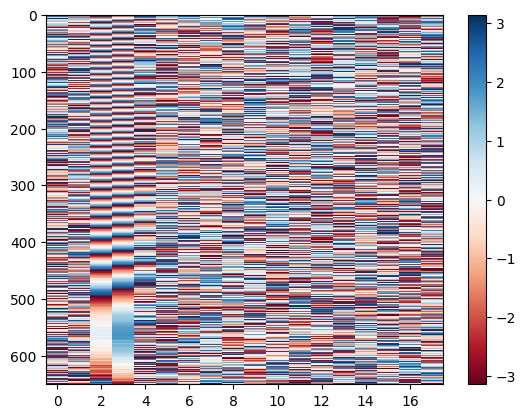

In [10]:
plt.imshow(vis_phase[:durations_chunks[n],:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

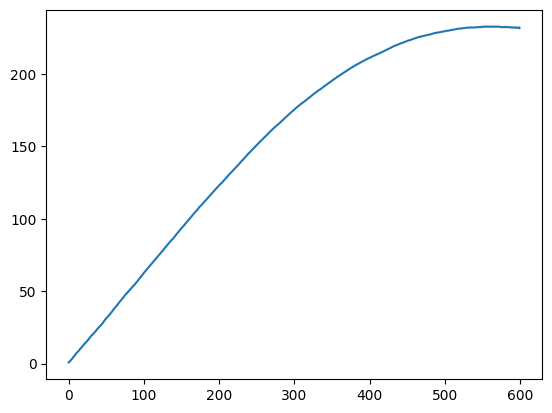

In [11]:
plt.plot(np.unwrap(vis_phase[0:600,2]))

In [12]:
print(vis_phase[0,2])

0.8059026


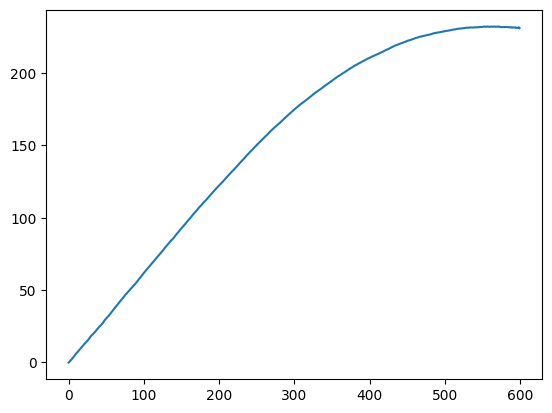

In [13]:
obs=np.unwrap(vis_phase[:600,2])-vis_phase[0,2]
plt.plot(obs)